<a href="https://colab.research.google.com/github/ranadeepbhuyan/cancer-mri-analysis/blob/main/slicing/PKG_UPENN_GBM_NIfTI_files_image_sliced_detection_along_z.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import cv2
import nibabel as nib

In [ ]:
import os

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
based_path = r"/content/drive/MyDrive/PKG - UPENN-GBM 3d to 2d /along z/Patients data into 64 parts"

In [ ]:
#fatching ids form data path
def pathListIntoIds(dirList):
    x = []
    for i in range(0,len(dirList)):
        x.append(dirList[i][dirList[i].rfind('/')+1:])
    return x


In [ ]:
list2 = []
path_of_paitents_data = [f.path for f in os.scandir(based_path)]
for i in range(len(path_of_paitents_data)):
  test = path_of_paitents_data[i]
  list1 = [f.path for f in os.scandir(test)]
  for i in list1:
    list2.append(i)

In [ ]:
list2[0]

'/content/drive/MyDrive/PKG - UPENN-GBM 3d to 2d /along z/Patients data into 64 parts/Patient no 2/UPENN-GBM-Patients-1-slice035_z_24.png'

In [ ]:
listno = []
for i in range(1,21):
  listno.append(f'{i}')

In [ ]:
listno[0]

'1'

In [ ]:
patients_data = []
for i in range(len(list2)):
  test = list2[i].split('/')[7]
  test1 = test.split(' ')[2]
  for F in range(0,12):
    if test1 == listno[F]:
      patients_data.append(list2[i])

In [ ]:
len(patients_data)

39040

In [ ]:
patients_data.sort()

In [ ]:
def remove_blank_imgs(path):
  final_path =[]
  for i in range(len(path)):
    image = cv2.imread(path[i])
    if image.max() != image.min():
      final_path.append(path[i])
  return final_path


In [ ]:
final_ids1 = remove_blank_imgs(patients_data)

In [ ]:
len(final_ids1)

In [ ]:
def data_prepare(path):
  data_path = []
  data_ids = []
  #desired_width = 128
  #desired_height = 128
  for i in range(len(path)):
    img_data = cv2.imread(path[i])
    gray_image = cv2.cvtColor(img_data, cv2.COLOR_BGR2GRAY)
    #resized_image = cv2.resize(gray_image, (desired_width, desired_height), interpolation=cv2.INTER_LINEAR)
    test1 = path[i].split('z_')[1]
    test = test1.split('.png')[0]
    data_path.append(gray_image)
    data_ids.append(int(test))
  return data_path, data_ids


data_path, data_ids = data_prepare(final_ids1)

data_column = {'image_data': data_path,
        'class': data_ids}
data_set = pd.DataFrame(data_column)

In [ ]:
data_list = data_set['image_data'].tolist()
classes = data_set['class'].tolist()

In [ ]:
my_array = np.array(data_list)
y_data = np.array(classes)

In [ ]:
my_array.shape

(9743, 30, 30)

In [ ]:
from sklearn.model_selection import train_test_split

x_train, x_test, y_train, y_test = train_test_split(my_array,y_data, test_size=0.10)

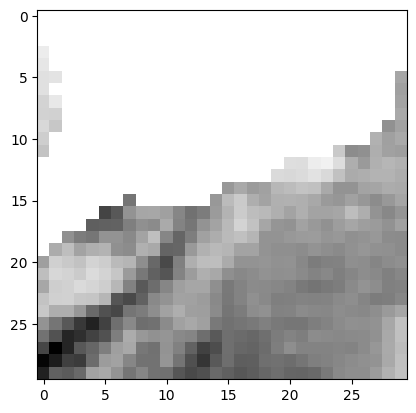

In [ ]:
from tensorflow.keras.utils import normalize

x_train = normalize(x_train, axis=1)
x_test = normalize(x_test, axis=1)
plt.imshow(x_train[1], cmap =plt.cm.binary)

In [ ]:
x_train = np.array(x_train).reshape(-1,30,30,1)
x_test = np.array(x_test).reshape(-1,30,30,1)
print(x_train.shape,x_test.shape)

(8768, 30, 30, 1) (975, 30, 30, 1)


In [ ]:
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Activation,Flatten, Dense, Dropout
from tensorflow.keras.models import Sequential
from tensorflow.keras.initializers import HeNormal

In [ ]:
model = Sequential()

model.add(Conv2D(32, (3,3), padding='same', input_shape=x_train.shape[1:]))
model.add(Activation('relu'))
model.add(Dropout(0.2))
model.add(MaxPooling2D(pool_size = (2, 2)))

model.add(Conv2D(64, (3,3),padding='same'))
model.add(Activation('relu'))
model.add(Dropout(0.2))
model.add(MaxPooling2D(pool_size = (2, 2)))

model.add(Conv2D(128, (3,3), padding='same'))
model.add(Activation('relu'))
model.add(Dropout(0.2))
model.add(MaxPooling2D(pool_size = (2, 2)))


model.add(Flatten())
model.add(Dense(512))
model.add(Activation('relu'))
model.add(Dropout(0.2))

model.add(Dense(256))
model.add(Activation('relu'))
model.add(Dropout(0.2))


model.add(Dense(64))
model.add(Activation('softmax'))


In [ ]:
model.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_15 (Conv2D)          (None, 30, 30, 32)        320       
                                                                 
 activation_30 (Activation)  (None, 30, 30, 32)        0         
                                                                 
 dropout_25 (Dropout)        (None, 30, 30, 32)        0         
                                                                 
 max_pooling2d_15 (MaxPooli  (None, 15, 15, 32)        0         
 ng2D)                                                           
                                                                 
 conv2d_16 (Conv2D)          (None, 15, 15, 64)        18496     
                                                                 
 activation_31 (Activation)  (None, 15, 15, 64)        0         
                                                      

In [ ]:
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
import tensorflow as tf

learning_rate = 0.001

optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)

model.compile(optimizer=optimizer, loss='sparse_categorical_crossentropy', metrics=['accuracy'])

earlystopping = EarlyStopping(monitor='val_loss',
                              mode='min',
                              verbose=1,
                              patience=15
                             )
checkpointer = ModelCheckpoint(filepath="clf-resnet-weights.hdf5",
                               verbose=1,
                               save_best_only=True
                              )
reduce_lr = ReduceLROnPlateau(monitor='val_loss',
                              mode='min',
                              verbose=1,
                              patience=5,
                              min_delta=0.0001,
                              factor=0.2
                             )

In [ ]:
h = model.fit(x_train, y_train, batch_size = 32, validation_split= 0.1, epochs=100, callbacks=[checkpointer, earlystopping, reduce_lr])

Epoch 1/100
247/247 [==============================] - ETA: 0s - loss: 1.7410 - accuracy: 0.4652
Epoch 1: val_loss improved from inf to 1.19774, saving model to clf-resnet-weights.hdf5
247/247 [==============================] - 3s 6ms/step - loss: 1.7410 - accuracy: 0.4652 - val_loss: 1.1977 - val_accuracy: 0.6454 - lr: 0.0010
Epoch 2/100
 23/247 [=>............................] - ETA: 1s - loss: 1.0231 - accuracy: 0.6617

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


239/247 [============================>.] - ETA: 0s - loss: 0.8974 - accuracy: 0.6985
Epoch 2: val_loss improved from 1.19774 to 0.84326, saving model to clf-resnet-weights.hdf5
247/247 [==============================] - 1s 5ms/step - loss: 0.8945 - accuracy: 0.6995 - val_loss: 0.8433 - val_accuracy: 0.7662 - lr: 0.0010
Epoch 3/100
241/247 [============================>.] - ETA: 0s - loss: 0.6857 - accuracy: 0.7621
Epoch 3: val_loss improved from 0.84326 to 0.72265, saving model to clf-resnet-weights.hdf5
247/247 [==============================] - 1s 5ms/step - loss: 0.6858 - accuracy: 0.7625 - val_loss: 0.7227 - val_accuracy: 0.7970 - lr: 0.0010
Epoch 4/100
241/247 [============================>.] - ETA: 0s - loss: 0.5580 - accuracy: 0.8056
Epoch 4: val_loss improved from 0.72265 to 0.55838, saving model to clf-resnet-weights.hdf5
247/247 [==============================] - 1s 5ms/step - loss: 0.5573 - accuracy: 0.8051 - val_loss: 0.5584 - val_accuracy: 0.8221 - lr: 0.0010
Epoch 5/100
2

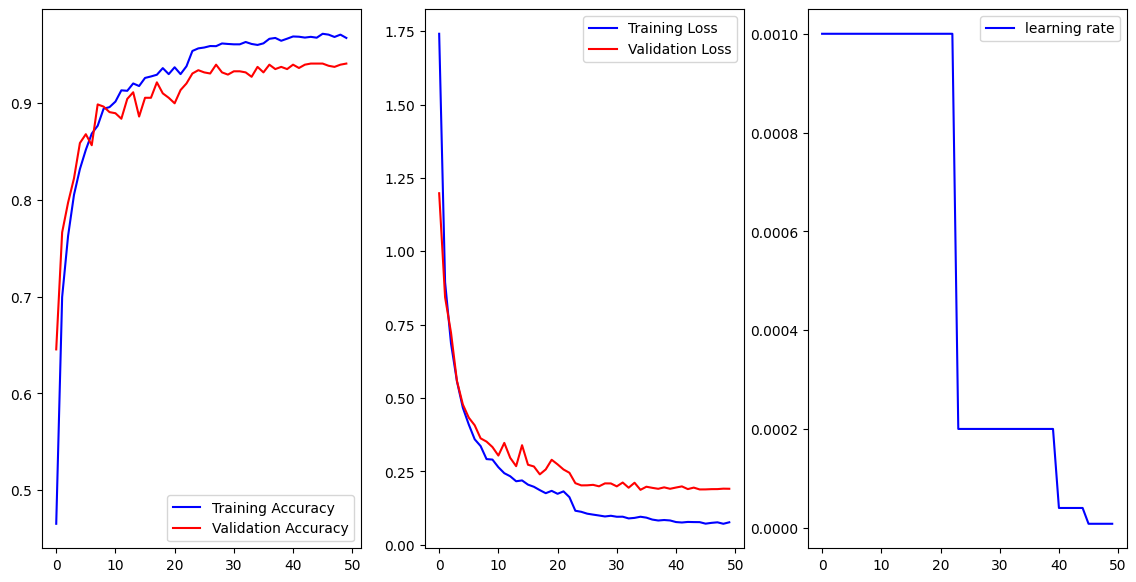

In [ ]:
acc=h.history['accuracy']
val_acc=h.history['val_accuracy']

epoch=range(len(acc))

loss=h.history['loss']
val_loss=h.history['val_loss']

learning_rate = h.history['lr']

f,ax=plt.subplots(1,3,figsize=(14,7))

ax[0].plot(epoch,acc,'b',label='Training Accuracy')
ax[0].plot(epoch,val_acc,'r',label='Validation Accuracy')
ax[0].legend()

ax[1].plot(epoch,loss,'b',label='Training Loss')
ax[1].plot(epoch,val_loss,'r',label='Validation Loss')
ax[1].legend()


ax[2].plot(epoch,learning_rate,'b',label='learning rate')
ax[2].legend()



plt.show()

In [ ]:
test_loss, test_acc = model.evaluate(x_test,y_test)

31/31 [==============================] - 0s 3ms/step - loss: 0.2171 - accuracy: 0.9262


In [ ]:
prediction = model.predict(x_test)

29/29 [==============================] - 0s 5ms/step


In [ ]:
len(prediction)

924

In [ ]:
not_match = []
not_match_ids = []
for i in range(len(prediction)):
  x = np.argmax(prediction[i])
  if x != y_test[i]:
    not_match.append(prediction[i])
    not_match_ids.append(i)

In [ ]:
for i in not_match_ids:
  print("Ids : ",i, "pred :",np.argmax(prediction[i]), "actual :", y_test[i])

Ids :  4 pred : 28 actual : 27
Ids :  5 pred : 17 actual : 25
Ids :  6 pred : 27 actual : 28
Ids :  15 pred : 52 actual : 53
Ids :  22 pred : 13 actual : 21
Ids :  31 pred : 44 actual : 27
Ids :  35 pred : 13 actual : 21
Ids :  64 pred : 35 actual : 34
Ids :  72 pred : 12 actual : 11
Ids :  73 pred : 40 actual : 39
Ids :  92 pred : 18 actual : 11
Ids :  94 pred : 39 actual : 30
Ids :  98 pred : 42 actual : 41
Ids :  102 pred : 23 actual : 22
Ids :  146 pred : 25 actual : 17
Ids :  149 pred : 41 actual : 33
Ids :  162 pred : 32 actual : 30
Ids :  190 pred : 13 actual : 12
Ids :  193 pred : 19 actual : 35
Ids :  205 pred : 42 actual : 45
Ids :  207 pred : 14 actual : 13
Ids :  214 pred : 34 actual : 35
Ids :  217 pred : 52 actual : 53
Ids :  220 pred : 33 actual : 35
Ids :  224 pred : 51 actual : 43
Ids :  228 pred : 53 actual : 52
Ids :  268 pred : 42 actual : 27
Ids :  278 pred : 40 actual : 39
Ids :  282 pred : 10 actual : 17
Ids :  286 pred : 22 actual : 19
Ids :  293 pred : 13 actua